In [2]:
import skinematics as skin
from scipy.spatial.transform import Rotation as R
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter,filtfilt
import scipy.integrate as sint
from scipy import stats

%matplotlib notebook


<IPython.core.display.Javascript object>


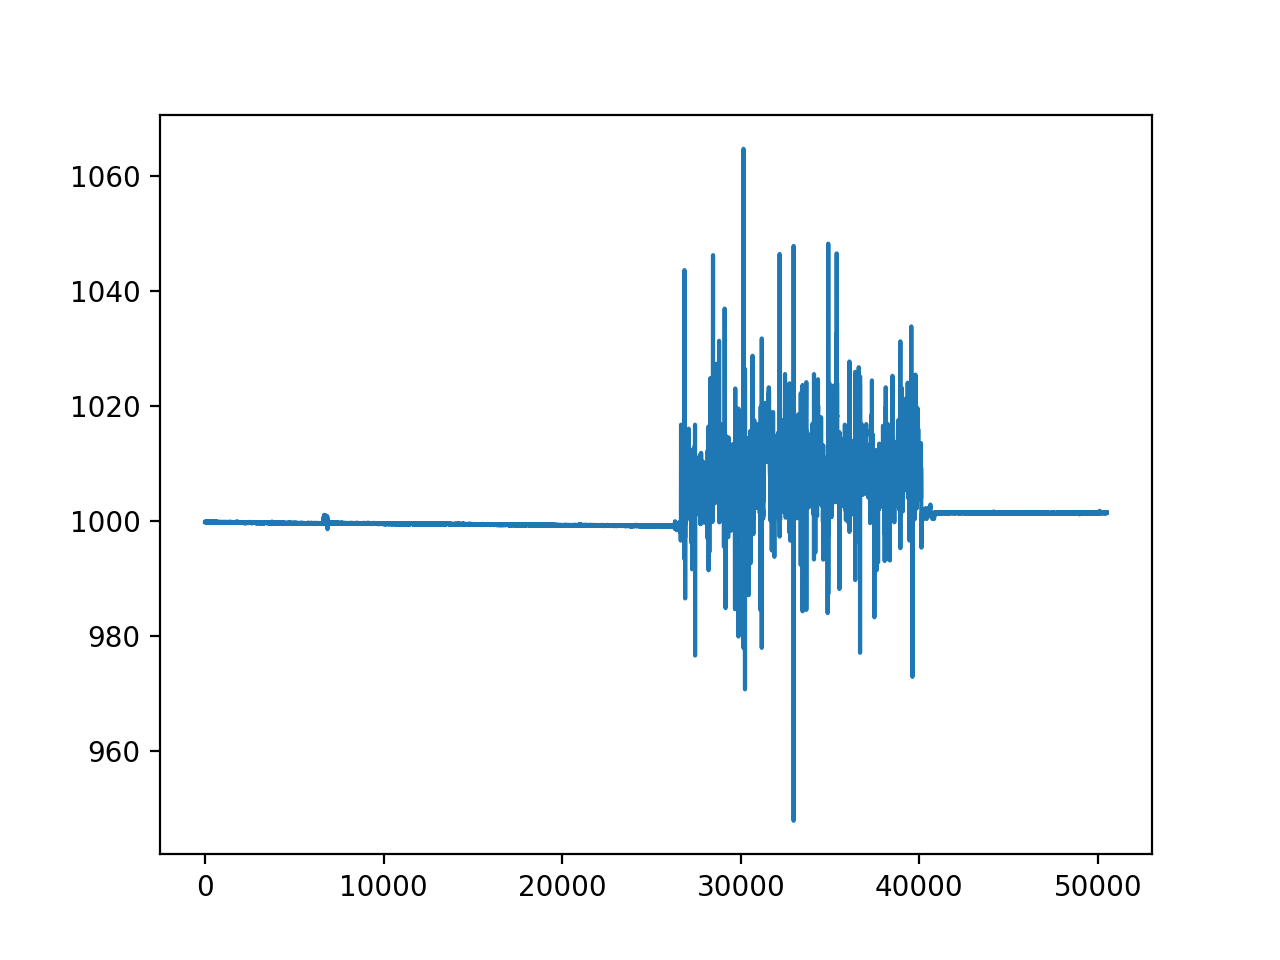

Index(['Time [s]', 'PL [hPa]', 'TL [C]', 'PC [hPa]', 'TC [C]', 'PR [hPa]',
       'TR [C]', 'EX [deg]', 'EY [deg]', 'EZ [deg]', 'QW [-]', 'QX [-]',
       'QY [-]', 'QZ [-]', 'MX [microT]', 'MY [microT]', 'MZ [microT]',
       'AXEarth [m/s2]', 'AYEarth [m/s2]', 'AZEarth [m/s2]', 'RX [rad/s]',
       'RY [rad/s]', 'RZ [rad/s]', 'CSM', 'CSA', 'CSR', 'CSTOT'],
      dtype='object')


In [29]:
def read_B_series_subfolders(path):
    # create a list of file and sub directories 
    # names in the given directory 
    subfolders = os.listdir(path)
    file_list = []

A14_path = "/Users/georgecowie/Documents/Master/Masteroppgave/data/2020/cross_section_deployments/A14_A1/"

A14B13 = pd.read_csv(A14_path+"/B130818162912.csv")
A14B17 = pd.read_csv(A14_path+"/B170818162956.csv")
A14B56 = pd.read_csv(A14_path+"/B560818162851.csv")
A14B78 = pd.read_csv(A14_path+"/B780818162912.csv")
A14B82 = pd.read_csv(A14_path+"/B820818152908.csv")
A14B84 = pd.read_csv(A14_path+"/B840818162908.csv")
A14B85 = pd.read_csv(A14_path+"/B850818162932.csv")

print(A14_B56.columns)

In [4]:
def butter_lowpass_filter(data, cutoff, fs, order):
    #low pass filter to filter out high frequency noise
    nyq = 0.5 * fs  # Nyquist Frequency
    normal_cutoff = cutoff / nyq
    # Get the filter coefficients 
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

"""Create a time array from B series indexes"""
def time_array(start,end):
    time_s = np.linspace(0,end-start,end-start)/100#convert to seconds
    return time_s

"""find index of time in video of a given drifter deployment"""
def index_finder(cp_times,time_s,start_n):
    length = len(cp_times)
    indexes = np.zeros(length)
    for i in range(length):#find indexes in time_s of the features
        indexes[i] = (next(j for j, _ in enumerate(time_s) if np.isclose(_, cp_times[i], 0.01)))    
    indexes = indexes.astype(int) + start_n
    return indexes

In [33]:
def rotate_N3_arrays(df):
    #Rotate N3 accelorometer data
    
    #Angular velocity
    RX = df['RX [rad/s]']
    RY = df['RX [rad/s]']
    RZ = df['RX [rad/s]']
    omega = np.transpose(np.array([RX,RY,RZ]))
    
    #Acceleration
    AX = df['AXEarth [m/s2]']
    AY = df['AYEarth [m/s2]']
    AZ = df['AZEarth [m/s2]']
    acc = np.transpose(np.array([AX,AY,AZ]))
    
    #Magnetometer
    MX = df['MX [microT]']
    MY = df['MY [microT]']
    MZ = df['MZ [microT]']
    mag = np.transpose(np.array([MX,MY,MZ]))
    
    #Euler angles pre calculated 
    EX = df['EX [deg]']
    EY = df['EY [deg]']
    EZ = df['EZ [deg]']
    euler = np.transpose(np.array([EX,EY,EZ]))
    
    
    r = R.from_euler("xyz", euler,degrees=True)
    rotate = r.apply(acc)
    return rotate,acc

acc_r,acc = rotate_N3_arrays(A14_B56) 

A14B13_accr,A14B13_acc = rotate_N3_arrays(A14B13)
A14B17_accr,A14B17_acc = rotate_N3_arrays(A14B17)
A14B56_accr,A14B56_acc = rotate_N3_arrays(A14B56)
A14B78_accr,A14B78_acc = rotate_N3_arrays(A14B78)
A14B82_accr,A14B82_acc = rotate_N3_arrays(A14B82)
A14B84_accr,A14B84_acc = rotate_N3_arrays(A14B84)
A14B85_accr,A14B85_acc = rotate_N3_arrays(A14B85)

#save data
drifter_id = "A14_B56_rotated"
save_path = "/Users/georgecowie/Documents/Master/Masteroppgave/data/2020/processed_drifter_data/rotated_data/"

A14B13_accr_df = pd.DataFrame(A14B13_accr)
A14B17_accr_df = pd.DataFrame(A14B17_accr)
A14B56_accr_df = pd.DataFrame(A14B56_accr)
A14B78_accr_df = pd.DataFrame(A14B78_accr)
A14B82_accr_df = pd.DataFrame(A14B82_accr)
A14B84_accr_df = pd.DataFrame(A14B84_accr)
A14B85_accr_df = pd.DataFrame(A14B85_accr)

A14B13_accr_df.to_csv(save_path + "A14B13_acc_rotated.csv")
A14B17_accr_df.to_csv(save_path + "A14B17_acc_rotated.csv")
A14B56_accr_df.to_csv(save_path + "A14B56_acc_rotated.csv")
A14B78_accr_df.to_csv(save_path + "A14B78_acc_rotated.csv")
A14B82_accr_df.to_csv(save_path + "A14B82_acc_rotated.csv")
A14B84_accr_df.to_csv(save_path + "A14B84_acc_rotated.csv")
A14B85_accr_df.to_csv(save_path + "A14B85_acc_rotated.csv")
#saved_data.to_csv(save_path+drifter_id+"rotated.csv")


In [7]:

"""start = 0
end = acc_r.shape[0]
# Filter requirements.
time = time_array(start,end)
T = time[-1]         # Sample Period
fs = 100.0       # sample rate, Hz
cutoff = 2#3      # desired cutoff frequency of the filter, Hz ,
order = 2       # sin wave can be approx represented as quadratic
n = int(T * fs) # total number of samples

for i in range(acc_r.shape[1]):
    y = butter_lowpass_filter(acc_r[:,i], cutoff, fs, order)
    x = butter_lowpass_filter(acc[:,i], cutoff, fs, order)


    #acc_r[:,i] = y
    #acc[:,i] = x"""

In [8]:
#load exel sheet of drifter observations
B56_A14_excel_sheet_path = "/Users/georgecowie/Documents/Master/Masteroppgave/data/drifter_videos/2020/Video_features_A14_B56_reanalysed.xlsx"
B56_A14_SS = pd.read_excel(B56_A14_excel_sheet_path,header = 8)
B56_A14_SS["Middle_t"] = B56_A14_SS["Stop_corr"]-(B56_A14_SS["Stop_corr"]-B56_A14_SS["Start_corr"])/2
A14steps = B56_A14_SS[B56_A14_SS["Feature id"] == 1].reset_index(drop=True)
A14other = B56_A14_SS[B56_A14_SS["Feature id"] == 2].reset_index(drop=True)
time_A14 = time_array(12500,26500)
A14_HF_idx = index_finder(B56_A14_SS["Middle_t"],time_A14,12500)-12500
steps_idx = index_finder(A14steps["Middle_t"],time_A14,12500)-12500
#A14_HF_stop_idx = index_finder(B56_A14_HF_stop,time_A14,start)-start


<IPython.core.display.Javascript object>


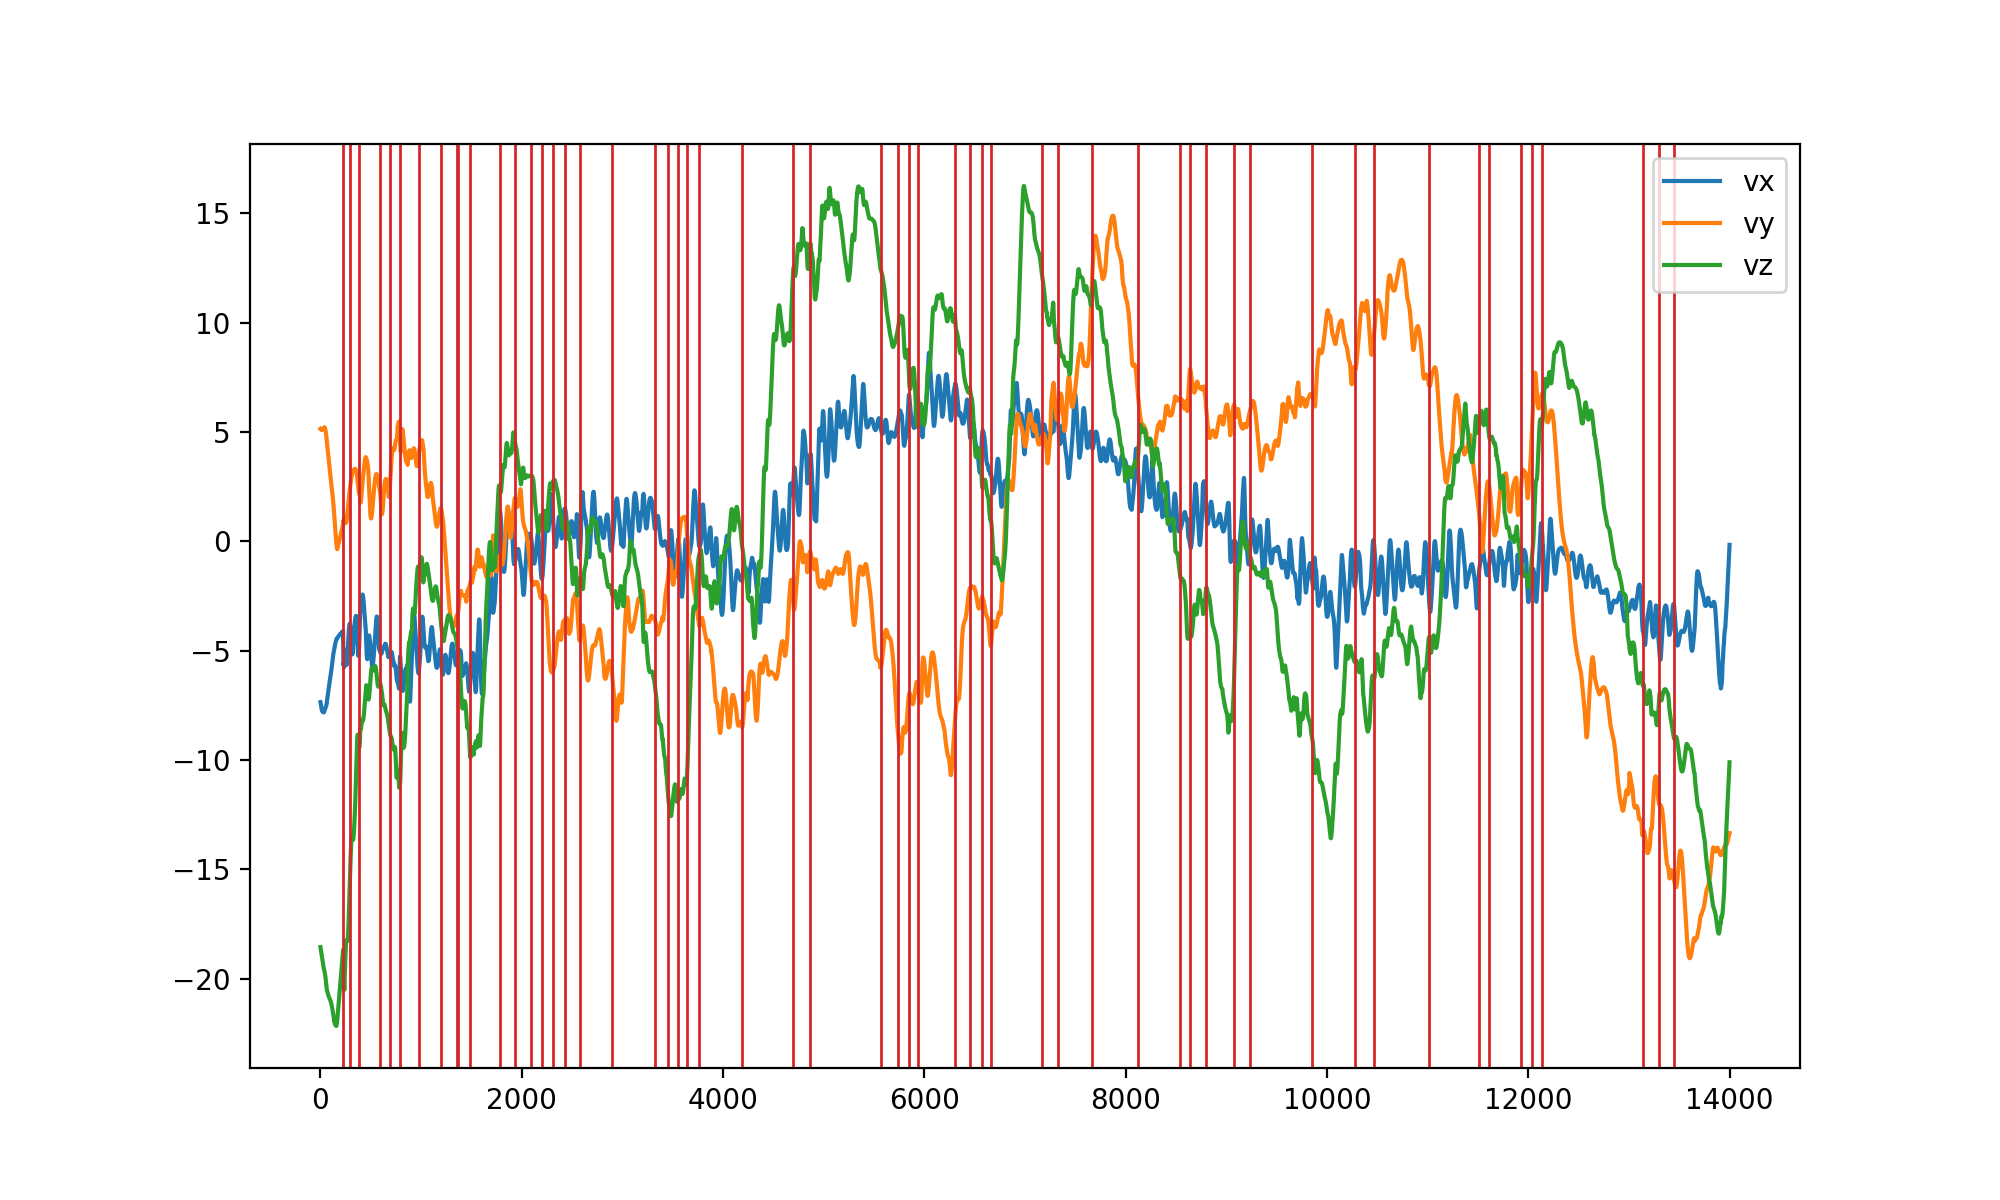

<IPython.core.display.Javascript object>


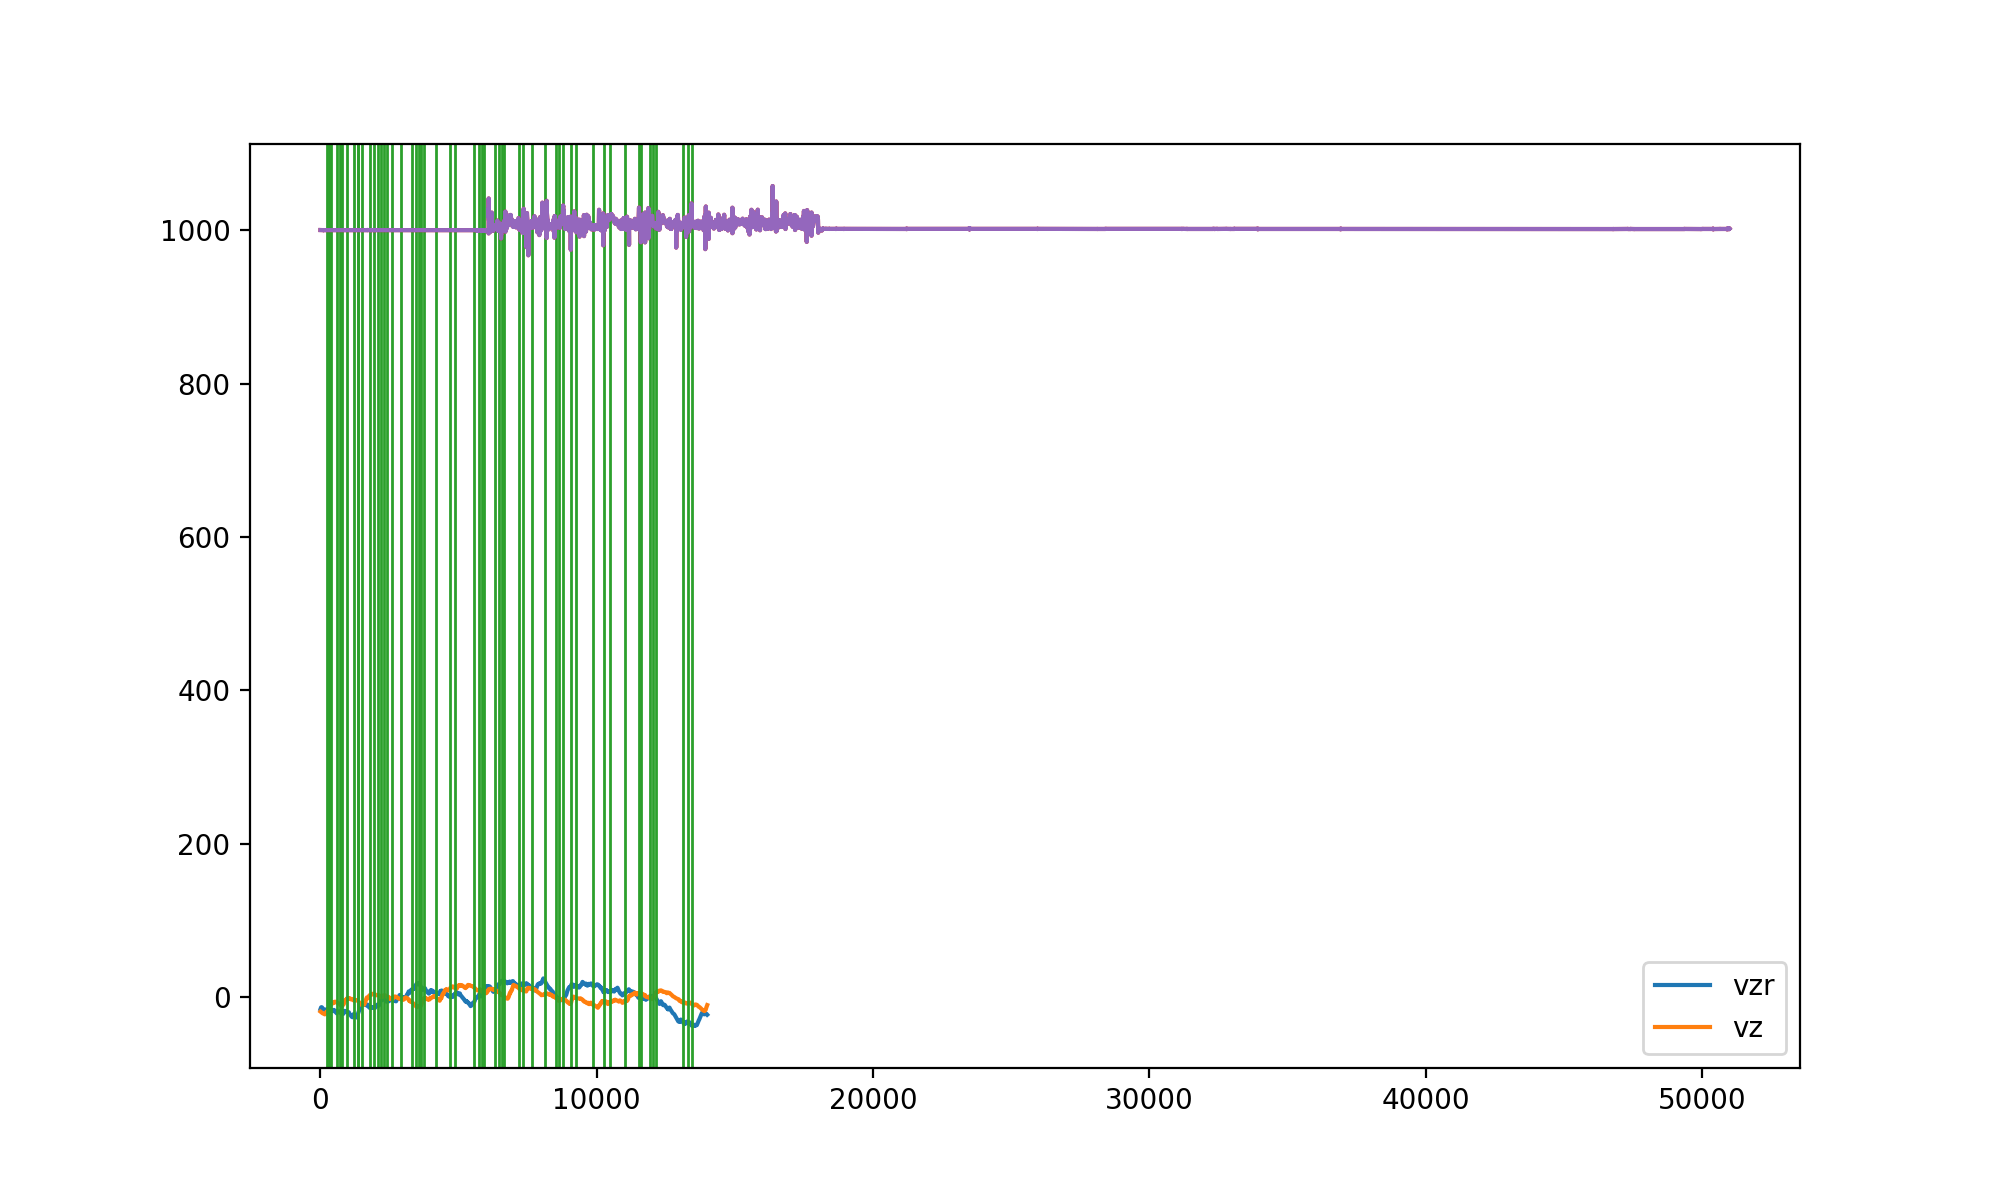

In [9]:
#Integrate acz
def integrate_acc(a):
    #a: acceleration array
    #integrate acceleration data to velocity and position
    start = 0
    end = len(a)
    time = time_array(start,end)
    #change time window? picewise
    #parametersise this based on mean velocity
    v = sint.cumtrapz(a, time) #velocity
    slope, intercept, r_value, p_value, std_err = stats.linregress(time[:-1],v)#detrend data
    trend = (slope*time + intercept)
    v = v - trend[0:-1]
    end = len(v)
    time = time_array(start,end)
    p = sint.cumtrapz(v, time)#position
    return v,p

#Unrotated
acc_tot = np.sqrt(acc[12500:26500,0]**2+acc[12500:26500,1]**2+acc[12500:26500,2]**2)
acc_x = acc[12500:26500,0]
acc_y = acc[12500:26500,1]
acc_z = acc[12500:26500,2]

#integrate
vx,px = integrate_acc(acc_x)
vy,py = integrate_acc(acc_y)
vz,pz = integrate_acc(acc_z)


fig, (ax) = plt.subplots(nrows=1, sharex=True,figsize=(10, 6))
ax.plot(vx,label = "vx")
ax.plot(vy,label = "vy")
ax.plot(vz,label = "vz")
ax.plot(steps_idx,vz[steps_idx],marker = "|",ls="None",markersize = 800)
plt.legend()
plt.show()


#rotated
acc_tot_r = np.sqrt(acc_r[12500:26500,0]**2+acc_r[12500:26500,1]**2+acc_r[12500:26500,2]**2)
acc_rx = acc_r[12500:26500,0]
acc_ry = acc_r[12500:26500,1]
acc_rz = acc_r[12500:26500,2]

#integrate
vx_r,px_r = integrate_acc(acc_rx)
vy_r,py_r = integrate_acc(acc_ry)
vz_r,pz_r = integrate_acc(acc_rz)

drifter_id = "A14_B56_rotated"
save_path = "/Users/georgecowie/Documents/Master/Masteroppgave/data/2020/processed_drifter_data/rotated_data/"

saved_data = pd.DataFrame(acc_rz)
saved_data.to_csv(save_path+drifter_id+".csv")


fig, (ax) = plt.subplots(nrows=1, sharex=True,figsize=(10, 6))
#ax.plot(vx_r,label = "vxr")
#ax.plot(vy_r,label = "vyr")
ax.plot(vz_r,label = "vzr")
ax.plot(vz,label = "vz")


ax.plot(steps_idx,vz_r[steps_idx],marker = "|",ls="None",markersize = 800)
plt.legend()
plt.show()



